# 노이즈, 라벨 오류 수정

### 원본 데이터
- `python main.py --data ../datasets/v0.0.2 --model ./model --mode train`
    - 'eval_loss': 1.6945666074752808, 'eval_f1': 0.34721457497955194

In [1]:
import spacy
import string
import re
import pandas as pd
from cleanlab.rank import get_label_quality_scores
from cleanlab.filter import find_label_issues
from cleanlab.dataset import health_summary
from llama import LlamaInference

# 한국어 모델 로드
nlp = spacy.load("ko_core_news_sm")

def noise_score_spacy(text):
    doc = nlp(text)  # 입력된 텍스트 토큰화
    word_count = len(doc) # 토큰 수 count
    
    # 노이즈 관련 점수 계산
    special_char_count = sum(1 for char in text if char in string.punctuation) # 특수문자의 개수 세기: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    non_korean_char_count = len(re.findall(r'[a-zA-Z0-9]', text))  # 한글이 아닌 문자(알파벳, 숫자) 개수 세기
    short_word_count = sum(1 for token in doc if len(token.text) == 1) # 길이가 1인 단어 수 세기 (노이즈 가능성 높음)
    separated_hangul_count = len(re.findall(r'[ㄱ-ㅎㅏ-ㅣ]', text)) # 한글 자모 분리 정도 감지 (ㅋ, ㄱ, ㅏ 등)
    irregular_case_count = sum(1 for i in range(1, len(text)) if text[i-1].islower() and text[i].isupper()) # 불규칙한 대소문자 패턴 (소문자 다음 대문자)
    
    # 품사 태그 다양성 (낮을수록 텍스트 단조롭고 노이즈 가능성 높을 것)
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    pos_diversity = len(pos_counts)
    
    # 노이즈 점수 계산
    noise_score = (
        (special_char_count * 2) +
        (non_korean_char_count * 1.5) +
        (short_word_count * 1.5) +
        (separated_hangul_count * 3) +
        (irregular_case_count * 2)
    ) / max(1, word_count)  # 단어 수로 나누어 정규화
    
    # 품사 다양성에 따른 보정 (다양성이 낮을수록 점수 증가)
    diversity_factor = max(1, 5 - pos_diversity) / 5
    noise_score *= (1 + diversity_factor)
    
    # 최종 점수 범위 조정 (0-100 사이)
    final_score = min(100, max(0, noise_score * 20))
    
    return final_score

## 노이즈 수정
- 번역기 이용: 성능 안좋음
- LLM 이용: Llama 3.2B instruct 이용

`!huggingface-cli login`로 로그인 필요

In [ ]:
llama_model_name = "meta-llama/Llama-3.1-8B-Instruct"
prompt_path = "./prompt/prompt_ko_v1.txt"
example_path = "./prompt/few_shot_v1.json"

inferencer = LlamaInference(llama_model_name, prompt_path, example_path)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
data_path = "../../datasets/v0.0.2/train.csv"
data = pd.read_csv(data_path)

# noise 점수가 30 이상 70 미만인 것들만 재작성. / 70 이상인건 삭제
data_denoise = data[(data.noise_score >= 30) & (data.noise_score < 70)].reset_index(drop=True)

data_denoise['denoised_text'] = ""
for idx, row in data_denoise.iterrows():
    denoised_text = inferencer.inference(row['text'])
    data_denoise.loc[idx,'denoised_text'] = denoised_text
    print(idx)

In [4]:
data_denoise.head()

,ID,text,target,noise_score,label_quality,denoised_text
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4,58.909091,0.215058,정파 1 미사일 KT(이용기간 2분 단위) Q분종류2보
1,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2,61.714286,0.271684,'김정은' 자주통일 새 시대 열린다...나가야 할 보안의 시대
2,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6,63.000000,0.275686,미 대선 앞두고 R2F단 발... 비해 감시 강화
3,ynat-v1_train_00006,프로야구~롯TKIAs광주 경기 y천취소,1,60.000000,0.392143,프로야구~롯데 자이언츠 광주 경기 취소
4,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...,4,44.000000,0.099699,아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳고 4위와 1점차


In [5]:
data_denoise[data_denoise.denoised_text == "복구 불가"].head()

,ID,text,target,noise_score,label_quality,denoised_text
5,ynat-v1_train_00010,oi 매력 R모h츠a열#w3약 >l·주가 고Q/진,5,64.800000,0.197690,복구 불가
23,ynat-v1_train_00067,x콩-P면금[T 나%\…g트=물J1h나고 지>철 %기고,6,64.615385,0.145765,복구 불가
52,ynat-v1_train_00152,김정은 $향gIx x산시 za,2,69.600000,0.275045,복구 불가
54,ynat-v1_train_00168,"(말\N 여행 aiq *#의 q…e을 반3는 ?딧M""<1짝",0,63.200000,0.159596,복구 불가
68,ynat-v1_train_00216,"k@ w고지;~ 반정,시/에 美X사주한 1)",6,64.800000,0.231543,복구 불가


In [6]:
data_denoise.to_csv("../../datasets/v0.0.2/train_rewritten.csv", index=False)

In [9]:
# 노이즈 제거한 데이터
data_denoise_final = data_denoise[data_denoise.denoised_text != "복구 불가"]  # 복구 불가한 텍스트 제외
data_denoise_final['text'] = data_denoise_final['denoised_text']  # 재작성된 텍스트로 text 대체
data_denoise_final = data_denoise_final.drop(['denoised_text'], axis=1)
data_clear = data[data.noise_score < 30]
denoised_final = pd.concat([data_clear, data_denoise_final], axis=0)  # 깨끗한 데이터 (노이즈 점수 < 30)와 재작성된 데이터 합치기

# 노이즈 점수 재계산
denoised_final['noise_score'] = denoised_final['text'].apply(noise_score_spacy)

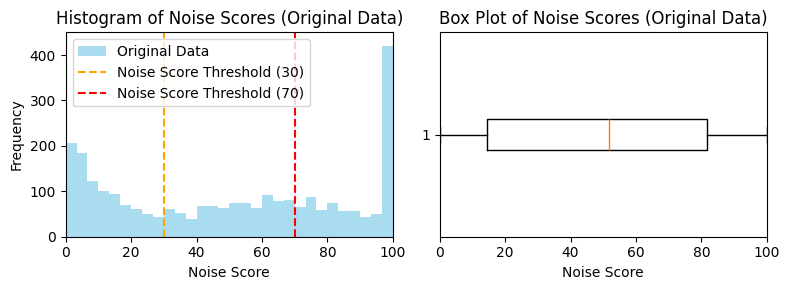

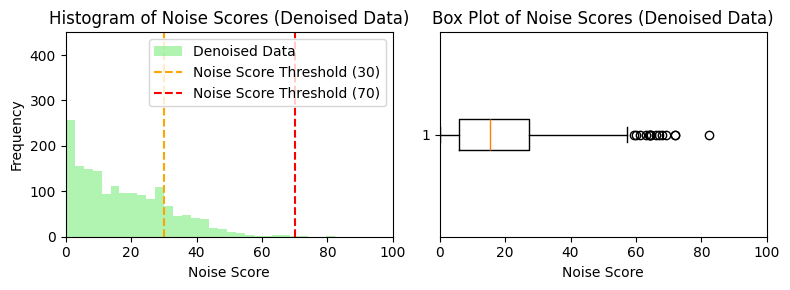

In [12]:
import matplotlib.pyplot as plt

# Step 1: 원본 데이터의 노이즈 점수 분포 시각화 (히스토그램 및 박스플롯)
plt.figure(figsize=(8, 3))

# Histogram - Original data
plt.subplot(1, 2, 1)
plt.hist(data['noise_score'], bins=30, color='skyblue', alpha=0.7, label='Original Data')
plt.axvline(x=30, color='orange', linestyle='--', label='Noise Score Threshold (30)')
plt.axvline(x=70, color='red', linestyle='--', label='Noise Score Threshold (70)')
plt.xlim(0,100)
plt.ylim(0, 450)
plt.xlabel("Noise Score")
plt.ylabel("Frequency")
plt.title("Histogram of Noise Scores (Original Data)")
plt.legend()

# Box Plot - Original data
plt.subplot(1, 2, 2)
plt.boxplot(data['noise_score'], vert=False)
plt.xlim(0,100)
plt.xlabel("Noise Score")
plt.title("Box Plot of Noise Scores (Original Data)")

plt.tight_layout()
plt.show()

# Step 2: 노이즈 제거 후 데이터의 노이즈 점수 재계산 및 시각화
plt.figure(figsize=(8, 3))

# Histogram - Denoised data
plt.subplot(1, 2, 1)
plt.hist(denoised_final['noise_score'], bins=30, color='lightgreen', alpha=0.7, label='Denoised Data')
plt.axvline(x=30, color='orange', linestyle='--', label='Noise Score Threshold (30)')
plt.axvline(x=70, color='red', linestyle='--', label='Noise Score Threshold (70)')
plt.xlim(0,100)
plt.ylim(0, 450)
plt.xlabel("Noise Score")
plt.ylabel("Frequency")
plt.title("Histogram of Noise Scores (Denoised Data)")
plt.legend()

# Box Plot - Denoised data
plt.subplot(1, 2, 2)
plt.boxplot(denoised_final['noise_score'], vert=False)
plt.xlim(0,100)
plt.xlabel("Noise Score")
plt.title("Box Plot of Noise Scores (Denoised Data)")

plt.tight_layout()
plt.show()

## label 오류 데이터 제거

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
os.environ['WANDB_DISABLED'] = 'true'

class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        targets = data['target']
        self.inputs = []; self.labels = []
        for text, label in zip(input_texts, targets):
            tokenized_input = tokenizer(text, padding='max_length', max_length=50, truncation=False, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }

    def __len__(self):
        return len(self.labels)

f1 = evaluate.load('f1')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average='macro')


train_data = pd.read_csv("../../datasets/v0.0.3/train.csv")
val_data = pd.read_csv("../../datasets/v0.0.3/validation.csv")

# Dataset 준비
train_dataset = BERTDataset(train_data, tokenizer)
val_dataset = BERTDataset(val_data, tokenizer)

# Trainer 설정
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
training_args = TrainingArguments(
    output_dir=f'./outputs',
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    do_predict=True,
    logging_strategy='epoch',
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=100,
    # eval_steps=100,
    # save_steps=100,
    save_total_limit=1,
    learning_rate= 2e-05, # 가능
    adam_beta1 = 0.9, # 불가
    adam_beta2 = 0.999, # 불가
    adam_epsilon=1e-08, # 불가
    weight_decay=0.01, # 불가
    lr_scheduler_type='linear', # 불가
    per_device_train_batch_size=32, # 가능
    per_device_eval_batch_size=32, # 32인 건 이유가 있다.
    num_train_epochs=2, # 불가
    # load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    seed=SEED, # 불가? 가급적 건드리지 말기
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

# 모델 학습
trainer.train()

# 학습 결과 평가
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(f"F1 Score: {eval_results['eval_f1']:.4f}")

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.952200,1.772822,0.369701
2,1.837900,1.664312,0.495439


F1 Score: 0.4954


In [3]:
model.eval()

# Validation 데이터에 대해 예측 확률 계산
val_loader = DataLoader(val_dataset, batch_size=32)
pred_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_probs.extend(probs.cpu().numpy())

pred_probs = np.array(pred_probs)


# Train 데이터에 대해 예측 확률 계산
train_loader = DataLoader(train_dataset, batch_size=32)
train_pred_probs = []

with torch.no_grad():
    for batch in tqdm(train_loader):
        inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        train_pred_probs.extend(probs.cpu().numpy())

train_pred_probs = np.array(train_pred_probs)

100%|██████████| 54/54 [00:01<00:00, 40.49it/s]


In [4]:
# 라벨 품질 점수 계산
label_quality_scores = get_label_quality_scores(
    labels=train_data['target'].values,
    pred_probs=train_pred_probs
)

# train_data 'label_quality' 열 재할당
train_data['label_quality'] = label_quality_scores

In [5]:
# 전체적인 라벨 품질 측정
class_names=[0,1,2,3,4,5,6]
health_summary(train_data['target'], train_pred_probs, class_names=class_names)

----------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary          |
|   for your dataset with 1,706 examples and 7 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.        |
----------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Name,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,0,0,176,80,0.752137,0.579710,0.247863
1,4,4,175,96,0.751073,0.623377,0.248927
2,3,3,135,136,0.581897,0.583691,0.418103
3,1,1,146,143,0.557252,0.552124,0.442748
4,6,6,137,185,0.545817,0.618729,0.454183
5,2,2,134,130,0.529644,0.522088,0.470356
6,5,5,124,257,0.514523,0.687166,0.485477



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Name A,Class Name B,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,5,6,5,6,77,0.045135
1,3,5,3,5,68,0.039859
2,4,5,4,5,68,0.039859
3,1,5,1,5,63,0.036928
4,2,5,2,5,62,0.036342
5,1,4,1,4,53,0.031067
6,0,2,0,2,53,0.031067
7,1,6,1,6,52,0.030481
8,0,6,0,6,52,0.030481
9,2,6,2,6,52,0.030481



 * Overall, about 54% (917 of the 1,706) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.46.

Generated with <3 from Cleanlab.



{'overall_label_health_score': 0.4624853458382181,
 'joint': array([[0.03399766, 0.01641266, 0.01758499, 0.01289566, 0.01641266,
         0.02168816, 0.01817116],
        [0.00468933, 0.06799531, 0.0123095 , 0.01758499, 0.01172333,
         0.02051583, 0.01875733],
        [0.01348183, 0.00820633, 0.06975381, 0.00820633, 0.00468933,
         0.02520516, 0.01875733],
        [0.00644783, 0.01172333, 0.014068  , 0.05685815, 0.00820633,
         0.02344666, 0.01524033],
        [0.00644783, 0.01934349, 0.00937866, 0.01524033, 0.03399766,
         0.03165299, 0.02051583],
        [0.003517  , 0.01641266, 0.01113716, 0.01641266, 0.00820633,
         0.06858148, 0.01699883],
        [0.0123095 , 0.01172333, 0.01172333, 0.00937866, 0.007034  ,
         0.02813599, 0.06682298]]),
 'classes_by_label_quality':    Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
 0           0            0           176                    80     0.752137   
 1           4            4  

In [6]:
ordered_label_issues = find_label_issues(
    labels=train_data['target'].values,
    pred_probs=train_pred_probs,
    return_indices_ranked_by='self_confidence',
)
issue_indices = set(ordered_label_issues)

# 라벨 이슈 있는 데이터 삭제
cleaned_train_data = train_data[~train_data.index.isin(issue_indices)].reset_index(drop=True)
print(f"Original dataset size: {len(train_data)}, Cleaned dataset size: {len(cleaned_train_data)}")

train_data.to_csv("../../datasets/v0.0.3/train.csv", index=False)  # 라벨 점수도 다시 계산해서 저장
cleaned_train_data.to_csv("../../datasets/v0.0.4/train.csv", index=False)  # 997개 데이터

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Original dataset size: 1706, Cleaned dataset size: 997


## 라벨링 오류 있는 데이터 재라벨
유사한 inferenced_label을 기준으로 클러스터링한 후, 각 클러스터 내에서 label_quality2 점수가 높은 데이터를 신뢰할 수 있는 것으로 간주하고 이를 대표 라벨로 사용해 다른 데이터들을 재라벨
1. 라벨 클러스터링: inferenced_label을 텍스트로 사용해 임베딩한 뒤, 유사도를 기준으로 클러스터링 수행. (KR-SBERT 등 딥러닝 모델 사용)
2. 라벨 기준 설정: 각 클러스터에서 label_quality2가 가장 높은 상위 10개 데이터의 target 라벨 대해 hard voting 진행 -> 해당 클러스터의 대표 라벨로 설정
3. 라벨 재할당: 클러스터 내의 모든 데이터의 target 값을 대표 라벨로 업데이트하여 재라벨

In [1]:
import pandas as pd

train_data = pd.read_csv("../../datasets/v0.0.3/train.csv")
train_data.head()

,ID,text,target,noise_score,label_quality
0,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다,0,19.636364,0.093559
1,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,4.500000,0.260287
2,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,1,24.000000,0.157298
3,ynat-v1_train_00012,황총리 각 부처 비상대비태세 철저히 강구해야,2,6.000000,0.192630
4,ynat-v1_train_00016,공사업체 협박에 분쟁해결 명목 돈 받은 언론인 집행유예,3,6.000000,0.196434


In [ ]:
from llama import LlamaInference

llama_model_name = "meta-llama/Llama-3.1-8B-Instruct"
labeling_prompt_path = "./prompt/labeling_prompt_ko_v2.txt"
labeling_example_path = "./prompt/labeling_few_shot_v2.json"

inferencer2 = LlamaInference(llama_model_name, labeling_prompt_path, labeling_example_path)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
train_data['inferenced_label'] = ""
for idx, row in train_data.iterrows():
    inferenced_label = inferencer2.inference(row['text'])
    train_data.loc[idx,'inferenced_label'] = inferenced_label
    print(idx, inferenced_label)

In [7]:
train_data.to_csv("../../datasets/v0.0.5/train_tmp.csv", index=False)

#### 라벨 매핑 정보 (추측)
- 0: 생활문화
- 1: 스포츠
- 2: 정치
- 3: 사회
- 4: IT과학
- 5: 경제
- 6: 세계

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from collections import Counter

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
train_data = pd.read_csv("../../datasets/v0.0.5/train_tmp.csv")

In [4]:
train_data

,ID,text,target,noise_score,label_quality,inferenced_label
0,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다,0,19.636364,0.093559,"경제: 빚, 부채, 결혼"
1,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,4.500000,0.260287,"사회: 대통령, 지진, 방문"
2,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,1,24.000000,0.157298,"금융: 투자, 옵션, 매매"
3,ynat-v1_train_00012,황총리 각 부처 비상대비태세 철저히 강구해야,2,6.000000,0.192630,"정치: 정부, 비상, 대비"
4,ynat-v1_train_00016,공사업체 협박에 분쟁해결 명목 돈 받은 언론인 집행유예,3,6.000000,0.196434,"사회: 협박, 언론인, 형사"
...,...,...,...,...,...,...
1701,ynat-v1_train_02784,"고려대 vs 5학년 결승 격돌…일, 3대0 농구 챔피언",1,30.545455,0.339997,"스포츠: 농구, 대회, 우승"
1702,ynat-v1_train_02788,남원소식 춘향학당 장로 모집,0,0.000000,0.157016,"교육: 춘향학당, 장로, 교육"
1703,ynat-v1_train_02789,"이총리, 세월호 참사 희생자 가족들과 함께 추모... ""그날 밤의 기억은 아직도 꽤...",2,25.411765,0.157126,"사회: 추모, 세월호, 희생자"
1704,ynat-v1_train_02790,프로농구 개막③ 헤인즈의 1만점·양동근의 900스틸...,3,40.500000,0.120524,"스포츠: 농구, 기록, 선수"


In [ ]:
# Step 1: llama로 추정된 라벨에 대한 임베딩 계산
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
label_embeddings = model.encode(train_data['inferenced_label'].tolist())

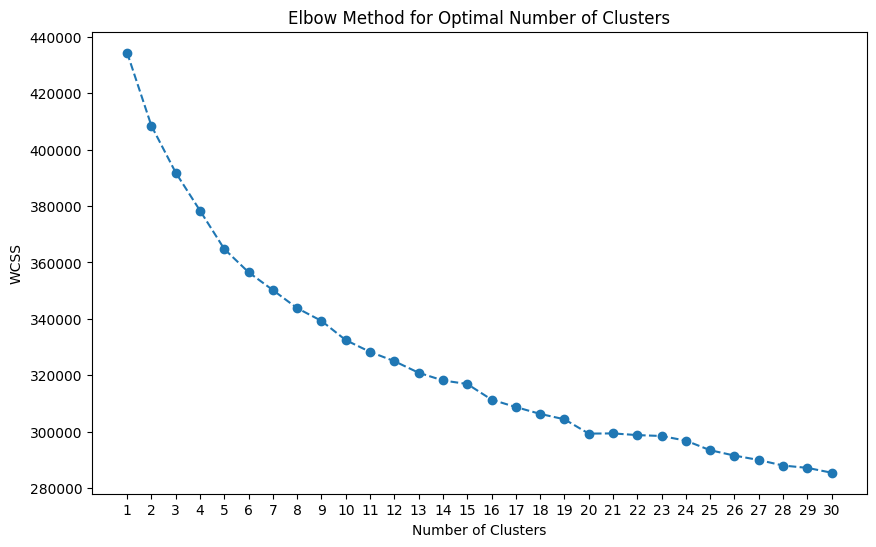

In [31]:
# within cluster sum of squares
import matplotlib.pyplot as plt

wcss = []
max_clusters = 30  # 테스트할 최대 클러스터 수
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(label_embeddings)
    wcss.append(kmeans.inertia_)

# Elbow plot 그리기 -> 딱히 Elbow라고 할 만한 지점 보이지 않음
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, max_clusters + 1))
plt.show()

In [32]:
# Step 2: 임베딩 클러스터링 수행 (7개 클러스터)
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_data['cluster'] = kmeans.fit_predict(label_embeddings)

# Step 3: 각 클러스터에서 label_quality 값이 높은 상위 10개 데이터의 최빈 target 값 추출 -> 대표 라벨로 생각
cluster_to_label_map = {}
for cluster in train_data['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster]
    top_10_data = cluster_data.nlargest(10, 'label_quality')  # 상위 10개 데이터 추출
    most_common_label = Counter(top_10_data['target']).most_common(1)[0][0]  # 최빈 라벨 추출
    cluster_to_label_map[cluster] = most_common_label

# Step 4: 각 클러스터에 따라 재라벨 수행
train_data['target_relabelled'] = train_data['cluster'].map(cluster_to_label_map)

In [33]:
train_data.head()

,ID,text,target,noise_score,label_quality,inferenced_label,cluster,target_relabelled
0,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다,0,19.636364,0.093559,"경제: 빚, 부채, 결혼",4,5
1,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,4.500000,0.260287,"사회: 대통령, 지진, 방문",5,6
2,ynat-v1_train_00011,NH투자 1월 옵션 만기일 매도 우세,1,24.000000,0.157298,"금융: 투자, 옵션, 매매",23,5
3,ynat-v1_train_00012,황총리 각 부처 비상대비태세 철저히 강구해야,2,6.000000,0.192630,"정치: 정부, 비상, 대비",26,6
4,ynat-v1_train_00016,공사업체 협박에 분쟁해결 명목 돈 받은 언론인 집행유예,3,6.000000,0.196434,"사회: 협박, 언론인, 형사",17,6


- 0 -> 6 (세계)
- 1 -> 1 (스포츠)
- 2 -> 4 (IT과학)
- 3 -> 0 (생활문화)
- 4 -> 5 (경제)
- 5 -> 
- 6 -> 
- 7 -> 
- 8 -> 
- 9 -> 
- 10 -> 
- 11 -> 
- 12 -> 
- 13 -> 
- 14 -> 

In [43]:
train_data[train_data.cluster == 2].sort_values(by="label_quality", ascending=False)

,ID,text,target,noise_score,label_quality,inferenced_label,cluster,target_relabelled
695,ynat-v1_train_02091,최신폰 갤노트8이 무료…이통사 과장광고 눈살,5,10.285714,0.255508,"통신: 광고, 과장, 서비스",2,5
1487,ynat-v1_train_02019,?별재난... 괴산·천안 전파사용료 감면,3,33.000000,0.239872,"경제: 전파, 요금, 감면",2,5
1443,ynat-v1_train_01828,1인당 스마트폰 데이터 사용량 6GB 눈앞… 동영상이 59%,5,33.818182,0.239219,"통신: 데이터, 스마트폰, 동영상",2,5
723,ynat-v1_train_02152,KT 할인 혜택 2배 더블할인 멤버십 시즌제 도입,5,13.500000,0.237164,"통신: 할인, 멤버십, 서비스",2,5
600,ynat-v1_train_01814,헬로모바일 어르신 대상 평생 반값 요금제 출시,5,0.000000,0.233832,"통신: 요금제, 모바일, 할인",2,5
1271,ynat-v1_train_01173,5G 스마트폰 Y대 기본금 오르다…월 5만5천원 종합,5,32.400000,0.227747,"경제: 통신, 5G, 요금",2,5
1507,ynat-v1_train_02111,"SKT, 세계 최초 5G 가입자 100만 명 돌파",5,48.000000,0.217307,"통신: 5G, 가입자, 통신",2,5
297,ynat-v1_train_00910,5기 방통위 정치 후견주의 극복하고 독립성 강화해야,5,5.142857,0.215845,"통신: 방송, 통신, 독립",2,5
113,ynat-v1_train_00310,SK텔레콤 충청 지역 폭우피해 통신망 복구,3,14.000000,0.212159,"통신: 통신망, 복구, 자연재해",2,5
767,ynat-v1_train_02263,5월 연휴 기간 12만명이 통신사 바꿨다…작년보다 30% 증가,5,27.272727,0.206208,"통신: 이동통신, 고객, 시장",2,5


In [44]:
# 몇개의 Label이 다시 라벨링되었는지 조회
total_length = len(train_data)
relabelled_data = len(train_data[train_data.target != train_data.target_relabelled])
print(f"재라벨링된 데이터 개수: {relabelled_data}개 / {total_length}개")

재라벨링된 데이터 개수: 1314개 / 1706개


In [50]:
train_data[train_data.cluster==0].inferenced_label.value_counts()

inferenced_label
외교    116
Name: count, dtype: int64

In [36]:
train_data[train_data.cluster==0].sort_values(by='label_quality', ascending=False)

,ID,text,target,noise_score,label_quality,inferenced_label,cluster,target_relabelled
1689,ynat-v1_train_02731,남중해 美4중국 군사적 충돌 가능성 높아…화해 틀 필요,6,10.800000,0.304282,"국제: 군사, 충돌, 외교",0,6
1576,ynat-v1_train_02373,S란에 시착한 르완다 여객기 '제재 탓' 70일 만에 귀환,6,28.363636,0.299220,"외교: 항공, 제재, 귀환",0,6
831,ynat-v1_train_02464,엘살바도르 베네수엘라 외교관 추방…베네수엘라도 맞대응,6,5.142857,0.297417,"외교: 추방, 외교, 관계",0,6
1002,ynat-v1_train_00250,민주성사 앞 북미정상회담에 美색야당 힘,2,19.200000,0.291694,"정치: 외교, 회담, 미국",0,6
1316,ynat-v1_train_01321,"朴대통령 '드 결정후' 첫 6자회의…중정과 접촉 ""어떤가?""",2,40.285714,0.291235,"정치: 대통령, 회의, 외교",0,6
...,...,...,...,...,...,...,...,...
190,ynat-v1_train_00504,UAE 단교 20개월만에 카타르 왕래 화물선 허용,4,25.714286,0.109237,"외교: 외교, 여행, 무역",0,6
192,ynat-v1_train_00507,朴대통령 에어포스원 탄 오바마와 15분간 북핵대응 긴급통화,0,15.428571,0.108234,"정치: 대통령, 외교, 북핵",0,6
763,ynat-v1_train_02250,앙숙 터키·그리스 화해 모색…그리스 총리 성소피아 방문,4,7.636364,0.106438,"외교: 외교, 화해, 방문",0,6
541,ynat-v1_train_01665,갈루치 북미접촉 결과 차기 美행정부에 전달,4,0.000000,0.105482,"외교: 갈루치, 미국, 외교",0,6


In [47]:
relabelled_data = train_data.copy()
relabelled_data['target'] = relabelled_data['target_relabelled']
relabelled_data = relabelled_data[['ID', "text", "target", "noise_score", "label_quality"]]
relabelled_data.to_csv("../../datasets/v0.0.5/train.csv")